In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, integrate, optimize
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

from gwbench import injections
from gwbench import network
from gwbench import snr

In [2]:
def p_m1(m1, alpha, beta, m_min, m_t, m_max):
    '''
    BBH merger primary mass PDF.
    '''
    if alpha != -1 and beta != -1:
        N1 = 1 / ((m_t**(alpha+1) - m_min**(alpha+1))/(alpha+1)
                  + m_t**(alpha-beta)*(m_max**(beta+1) - m_t**(beta+1))/(beta+1))
    else:
        if alpha == -1 and beta != -1:
            N1 = 1 / (np.log(m_t/m_min) + m_t**(alpha-beta) *
                      (m_max**(beta+1) - m_t**(beta+1))/(beta+1))
        elif alpha != -1 and beta == -1:
            N1 = 1 / ((m_t**(alpha+1) - m_min**(alpha+1)) /
                      (alpha+1) + m_t**(alpha-beta)*np.log(m_max/m_t))
        else:
            N1 = 1/(np.log(m_t/m_min) + m_t**(alpha-beta)*np.log(m_max/m_t))

    return np.piecewise(m1, [(m1 < m_min), (m1 >= m_min)*(m1 < m_t), (m1 >= m_t)*(m1 < m_max), (m1 >= m_max)],
                        [0, lambda m1: N1*m1**alpha, lambda m1: N1*m_t**(alpha-beta)*m1**beta, 0])

def p_q(q, gamma, q_min):
    '''
    BBH merger mass ratio PDF.
    '''
    Nq = (gamma+1)/(1-q_min**(gamma+1))
    return Nq * q**gamma


def p_z(z, z_min, z_max):
    '''
    BBH merger redshift PDF.
    '''
    Nz = 1/integrate.quad(lambda x: (1+x)**(2.6) /
                          (1 + ((1+x)/3.2)**(6.2)), z_min, z_max)[0]
    return Nz * (1+z)**(2.6)/(1 + ((1+z)/3.2)**(6.2))


def p_s(s, alpha_s, beta_s):
    '''
    BH spin PDF.
    '''
    N_s = 1 / integrate.quad(lambda ss: ss**(alpha_s-1)
                             * (1-ss)**(beta_s-1), 0, 1)[0]
    return N_s * s**(alpha_s-1)*(1-s)**(beta_s-1)


def R_mrg(z, R02, z_min, z_max):
    '''
    Volumetric merger rate density.
    '''
    return R02 * p_z(z, z_min, z_max)/p_z(0.2, z_min, z_max)

# Simple Power Law Test

In [3]:
def p_m1(m1, alpha, m_min, m_max):
    '''
    BBH merger primary mass PDF.
    '''
    if alpha != -1:
        N1 = 1 / ((m_max**(alpha+1) - m_min**(alpha+1))/(alpha+1))
    else:
        N1 = 1/(np.log(m_max/m_min))

    return np.piecewise(m1, [(m1 < m_min), (m1 >= m_min)*(m1 < m_max), (m1 >= m_max)],
                        [0, lambda m1: N1*m1**alpha, 0])

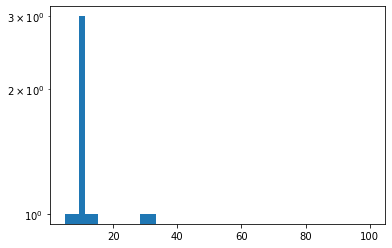

In [4]:
alpha= -3.5
beta= -3.5
m_min = 5
m_t = 100.
m_max = 100

num_injs = 10

m1 = np.linspace(m_min, m_max, 1000)

pdf_m1 = p_m1(m1, alpha, m_min, m_max)
cdf_m1 = integrate.cumulative_trapezoid(pdf_m1, m1, initial=0)
inv_cdf_m1 = interpolate.interp1d(cdf_m1 / cdf_m1[-1], m1)
m1_events = inv_cdf_m1(np.random.rand(num_injs))

plt.hist(m1_events, bins = np.geomspace(m_min, m_max, 20))
plt.semilogy()
plt.show()

In [5]:
q_min = 0.01
q_max = 0.99

# sample redshifts uniormly in [0.02, 50] based on Bohranian & Sathyaprakash (2022)
redshifts = np.random.uniform(0.02, 50, num_injs)

# sample mass 1 from power law pdf
m1_range = np.linspace(m_min, m_max, 1000)

pdf_m1 = p_m1(m1, alpha, m_min, m_max)
cdf_m1 = integrate.cumulative_trapezoid(pdf_m1, m1, initial=0)
inv_cdf_m1 = interpolate.interp1d(cdf_m1 / cdf_m1[-1], m1)

mass1 = inv_cdf_m1(np.random.rand(num_injs))

# sample q uniformly between q_min and q_max
q = np.random.uniform(q_min, q_max, num_injs)
mass2 = mass1 * q

Mcs = (mass1*mass2)**(3/5) / (mass1+mass2)**(1/5)
etas = (mass1*mass2) / (mass1+mass2)**2

# Convert source frame masses to detector frame masses
Mcs = Mcs * (1+redshifts)
mtotals = (mass1+mass2) * (1+redshifts)


In [6]:
DLs = cosmo.luminosity_distance(redshifts).value
print(DLs)
print(redshifts)

[289466.32872317 423373.94150427 107372.86537945 194321.78016474
 159071.15795322 108523.93499314 238764.98502626 298918.29319477
 431361.35745071 512126.83023369]
[25.11058633 35.62287424 10.3030429  17.48689727 14.60891963 10.40038814
 21.06967418 25.85947373 36.24441035 42.50272514]


# Broken Power Law

In [3]:
N_events = 500

seed = 329
# Initialize pseudo-random number generator:
np.random.seed(seed)

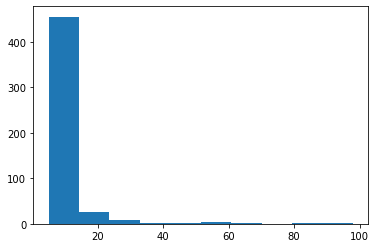

In [8]:
# Sample primary masses:
alpha=-3.5
beta=-2.
m_min = 5
m_t = 20.
m_max = 100

m1 = np.linspace(m_min, m_max, 10**5)

pdf_m1 = p_m1(m1, alpha, beta, m_min, m_t, m_max)
cdf_m1 = integrate.cumulative_trapezoid(pdf_m1, m1, initial=0)
inv_cdf_m1 = interpolate.interp1d(cdf_m1 / cdf_m1[-1], m1)
m1_events = inv_cdf_m1(np.random.rand(N_events))

plt.hist(m1_events)
# plt.semilogx()
plt.show()

In [15]:
# Sample secondary masses:
m2_events = np.zeros(N_events)
gamma = 0.
for i in range(0, N_events):
    q_min = m_min/m1_events[i]
    q = np.linspace(q_min, 1, 10**2)
    pdf_q = p_q(q, gamma, q_min)
    cdf_q = integrate.cumulative_trapezoid(pdf_q, q, initial=0)
    inv_cdf_q = interpolate.interp1d(cdf_q / cdf_q[-1], q)
    m2_events[i] = m1_events[i] * inv_cdf_q(np.random.rand())

In [16]:
alpha_s = 1.
beta_s = 2. 
# Sample primary spins:
s1 = np.linspace(0, 1, 10**3)
pdf_s1 = p_s(s1, alpha_s, beta_s)
cdf_s1 = integrate.cumulative_trapezoid(pdf_s1, s1, initial=0)
inv_cdf_s1 = interpolate.interp1d(cdf_s1 / cdf_s1[-1], s1)
s1_events = inv_cdf_s1(np.random.rand(N_events))
# Sample secondary spins:
s2 = np.linspace(0, 1, 10**3)
pdf_s2 = p_s(s2, alpha_s, beta_s)
cdf_s2 = integrate.cumulative_trapezoid(pdf_s2, s2, initial=0)
inv_cdf_s2 = interpolate.interp1d(cdf_s2 / cdf_s2[-1], s2)
s2_events = inv_cdf_s2(np.random.rand(N_events))

z_min = 0.1
z_out = 3.0
# Sample redshifts:
z = np.linspace(z_min, z_out, 10**3)
pdf_z = p_z(z, z_min, z_out)
cdf_z = integrate.cumulative_trapezoid(pdf_z, z, initial=0)
inv_cdf_z = interpolate.interp1d(cdf_z / cdf_z[-1], z)
z_events = inv_cdf_z(np.random.rand(N_events))
DL_events = cosmo.luminosity_distance(z_events)

# Sample external angles:
iota_events, ra_events, dec_events, psi_events = injections.angle_sampler(
    N_events, seed)


In [17]:
DL_events

<Quantity [ 4421.20337381, 15425.41696101, 13860.98553755, 12001.19986382,
           16887.15262674, 11164.2502077 , 12477.44130196, 13300.75092286,
            9966.28849721, 14978.11246918, 15308.39308665, 18842.82096944,
           16487.52782409,  7157.38484164, 21052.86397414, 15003.14924987,
            1277.53025133, 11240.09555819,  2578.95804802, 12893.08171205,
             710.21845019, 12336.9825558 , 24499.93310157, 17385.42404918,
            4492.39351304, 20973.01907592, 17683.91995317,  4206.6460152 ,
           10366.95461473,  8582.30762942,  4097.28179832,  1411.58632395,
            7986.76177349, 23267.48587279,  6058.22263685, 19243.89519057,
           20601.55400976, 14366.32408211,  8681.1471069 , 21609.86458562,
            6706.8626322 ,  6614.47863535, 19759.30373357, 13614.14443773,
            7865.55427054,  6322.99717341, 16715.05245378,  7422.26902069,
           14822.80782642,  9431.71549113, 15532.72815783,  7483.42829897,
            1619.81096226

# Infer Population Parameters

In [18]:
def fit_function(m1, alpha, beta, m_t):
    m_min = 1
    # m_t = 20
    m_max = 100
    '''
    BBH merger primary mass PDF.
    '''
    if alpha != -1 and beta != -1:
        N1 = 1 / ((m_t**(alpha+1) - m_min**(alpha+1))/(alpha+1)
                  + m_t**(alpha-beta)*(m_max**(beta+1) - m_t**(beta+1))/(beta+1))
    else:
        if alpha == -1 and beta != -1:
            N1 = 1 / (np.log(m_t/m_min) + m_t**(alpha-beta) *
                      (m_max**(beta+1) - m_t**(beta+1))/(beta+1))
        elif alpha != -1 and beta == -1:
            N1 = 1 / ((m_t**(alpha+1) - m_min**(alpha+1)) /
                      (alpha+1) + m_t**(alpha-beta)*np.log(m_max/m_t))
        else:
            N1 = 1/(np.log(m_t/m_min) + m_t**(alpha-beta)*np.log(m_max/m_t))

    return np.piecewise(m1, [(m1 < m_min), (m1 >= m_min)*(m1 < m_t), (m1 >= m_t)*(m1 < m_max), (m1 >= m_max)],
                        [0, lambda m1: N1*m1**alpha, lambda m1: N1*m_t**(alpha-beta)*m1**beta, 0])

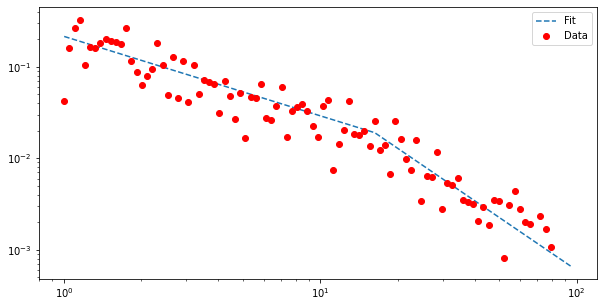

In [19]:
target_func = fit_function
bins = np.logspace(0, 2, 100)

y, X = np.histogram(m1_events, bins=bins, density=True)
X = X[:-1]
# plt.plot(X, y)
# plt.loglog()

popt, pcov = optimize.curve_fit(target_func, X, y, p0=[-0.8, -2.3, 30])

plt.figure(figsize=(10, 5))
plt.plot(X, target_func(X, *popt), '--', label='Fit')

plt.plot(X, y, 'ro', label='Data')
plt.loglog()
plt.legend()
plt.show()

In [20]:
popt

array([-0.86854724, -1.908422  , 16.29755224])

# Convert Population to gwbench Network objects

In [6]:
def get_network_response(inj_params, network_spec = ['CE2-40-CBO_C', 'CE2-20-CBO_S', 'ET_ET1', 'ET_ET2', 'ET_ET3'], approximant='IMRPhenomXAS', deriv_symbs_string = 'Mc eta DL tc phic iota ra dec psi'):
    
    # initialize the network with the desired detectors
    net = network.Network(network_spec)

    # choose the desired waveform 
    wf_model_name = 'lal_bbh'
    # pass the chosen waveform to the network for initialization
    net.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant})

    # pick the desired frequency range
    f_min = 5.
    f_max = 1024.
    d_f = 2**-4
    f = np.arange(f_min, f_max, d_f)

    # choose whether to take Earth's rotation into account
    use_rot = 0

    # pass all these variables to the network
    net.set_net_vars(
        f=f, inj_params=inj_params,
        deriv_symbs_string=deriv_symbs_string,
        use_rot=use_rot
        )

    # compute the WF polarizations
    net.calc_wf_polarizations()
    # compute the WF polarizations and their derivatives
    net.calc_wf_polarizations_derivs_num()

    # setup antenna patterns, location phase factors, and PSDs
    net.setup_ant_pat_lpf_psds()

    # compute the detector responses
    net.calc_det_responses()
    # compute the detector responses and their derivatives
    net.calc_det_responses_derivs_num()

    # calculate the network and detector SNRs
    net.calc_snrs()

    # calculate the network and detector Fisher matrices, condition numbers,
    # covariance matrices, error estimates, and inversion errors
    net.calc_errors()

    # calculate the 90%-credible sky area (in deg)
    net.calc_sky_area_90()

    return net

In [39]:
from gwbench import injections
mass_dict = {'dist': 'power', 'alpha': -1.5, 'mmin': 1., 'mmax':100.}
seed=42
num_injs = 1000
# Mcs, etas = injections.mass_sampler(mass_dict,num_injs,seed)

spin_dict = {'geom': 'spherical', 'dim':3, 'chi_lo':0., 'chi_hi':1.}
cosmo_dict = {'sampler': 'uniform_comoving_volume_rejection', 'zmin':0., 'zmax':3.}
data = injections.injections_CBC_params_redshift(cosmo_dict,mass_dict,spin_dict,num_injs=num_injs,seed=seed, redshifted=0)

Mcs, etas, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, iotas, ras, decs, psis, zs, DLs = data

In [40]:
len(Mcs)

1000

In [44]:
deriv_symbs_string = 'Mc eta DL tc phic iota ra dec psi'
param_list = deriv_symbs_string.split()
    
for i in range(1):
    inj_params = {
        'Mc':    Mcs[i],
        'eta':   etas[i],
        'chi1x': 0.,
        'chi2x': 0.,
        'chi1y': 0.,
        'chi2y': 0.,
        'chi1z': 0.,
        'chi2z': 0.,
        'DL':    DLs[i],
        'tc':    0,
        'phic':  0,
        'iota':  iotas[i],
        'ra':    ras[i],
        'dec':   decs[i],
        'psi':   psis[i],
        'gmst0': 0
        }

    
    net1 = get_network_response(inj_params=inj_params, approximant='IMRPhenomXAS')
    net2 = get_network_response(inj_params=inj_params, approximant='IMRPhenomD')

    net1.save_network(f'gwbench_networks/net_xas_{i}')
    net2.save_network(f'gwbench_networks/net_d_{i}')

Polarizations calculated.
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Detector responses calculated.
Calculate numeric derivatives of detector responses.
  CE2-40-CBO_C
  CE2-20-CBO_S
  ET_ET1
  ET_ET2
  ET_ET3
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  CE2-40-CBO_C
  CE2-20-CBO_S
  ET_ET1
  ET_ET2
  ET_ET3
Errors calculated.
Calculate 90% sky area.
Sky area calculated.
Polarizations calculated.
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Detector responses calculated.
Calculate numeric derivatives of detector responses.
  CE2-40-CBO_C
  CE2-20-CBO_S
  ET_ET1
  ET_ET2
  ET_ET3
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs c

# Parallelize the Network Calcs

In [1]:
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

In [3]:
task_list = range(100)
#parallelized version
#the enumerate function gives us a number i in addition
#to the task.  (In this specific case i is the same as task!  But that's
#not true usually)
for i,task in enumerate(task_list):
  #This is how we split up the jobs.
  #The % sign is a modulus, and the "continue" means
  #"skip the rest of this bit and go to the next time
  #through the loop"
  # If we had e.g. 4 processors, this would mean
  # that proc zero did tasks 0, 4, 8, 12, 16, ...
  # and proc one did tasks 1, 5, 9, 13, 17, ...
  # and do on.
  if i%size!=rank: continue
  print ("Task number %d (%d) being done by processor %d of %d" % (i, task, rank, size))
  print(task)

Task number 0 (0) being done by processor 0 of 1
0
Task number 1 (1) being done by processor 0 of 1
1
Task number 2 (2) being done by processor 0 of 1
2
Task number 3 (3) being done by processor 0 of 1
3
Task number 4 (4) being done by processor 0 of 1
4
Task number 5 (5) being done by processor 0 of 1
5
Task number 6 (6) being done by processor 0 of 1
6
Task number 7 (7) being done by processor 0 of 1
7
Task number 8 (8) being done by processor 0 of 1
8
Task number 9 (9) being done by processor 0 of 1
9
Task number 10 (10) being done by processor 0 of 1
10
Task number 11 (11) being done by processor 0 of 1
11
Task number 12 (12) being done by processor 0 of 1
12
Task number 13 (13) being done by processor 0 of 1
13
Task number 14 (14) being done by processor 0 of 1
14
Task number 15 (15) being done by processor 0 of 1
15
Task number 16 (16) being done by processor 0 of 1
16
Task number 17 (17) being done by processor 0 of 1
17
Task number 18 (18) being done by processor 0 of 1
18
Task

In [7]:
import pandas as pd

In [39]:
df = pd.DataFrame()

In [47]:
for i, lam in enumerate(np.linspace(1, 100, 10)):
    print(lam)

1.0
12.0
23.0
34.0
45.0
56.0
67.0
78.0
89.0
100.0


In [ ]:
hp1_pyc = FrequencySeries(net1.hfp, delta_f=delta_f)

hp2_pyc = FrequencySeries(net2.hfp, delta_f=delta_f)
full_faith, index = match(hp1_pyc, hp2_pyc, psd=psd, low_frequency_cutoff=net1.f[0])

# print("getting hybrid waveform")
hp_hyb, hc_hyb = get_hyb_wf(net1.hfp, net1.hfc, net2.hfp, net2.hfc, max_lam)
hp_hyb_pyc = FrequencySeries(hp_hyb, delta_f=delta_f)


# print("calculating faithfulness the pycbc way")
min_faith, index = match(hp1_pyc, hp_hyb_pyc, psd=psd, low_frequency_cutoff=net1.f[0])

# Compute the inner product (unoptimized faithfulness)   
hp1_norm = np.sum((hp1_pyc * np.conjugate(hp1_pyc) / psd).data)
hp2_norm = np.sum((hp2_pyc * np.conjugate(hp2_pyc) / psd).data)
hyb_norm = np.sum((hp_hyb_pyc * np.conjugate(hp_hyb_pyc) / psd).data)

full_inner_prod = np.abs(np.sum((hp1_pyc * np.conjugate(hp2_pyc)/psd).data)) / np.abs(np.sqrt(hp1_norm*hp2_norm))
min_inner_prod = np.abs(np.sum((hp1_pyc * np.conjugate(hp_hyb_pyc)/psd).data)) / np.abs(np.sqrt(hp1_norm*hyb_norm))


In [45]:
lams = np.zeros((4, 10))
lams[:, 8] =30
l_colnames = ['bias_'+str(id) for id in range(4)]
df[l_colnames] = lams.T
df


,bias_0,bias_1,bias_2,bias_3,faith_0,faith_1,faith_2,faith_3
0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
7,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
8,30.0,30.0,30.0,30.0,1.0,1.0,1.0,1.0
9,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [42]:
faiths = np.ones((4, 10))
f_colnames = ['faith_'+str(id) for id in range(4)]
df[f_colnames] = faiths.T
df

,bias_0,bias_1,bias_2,bias_3,faith_0,faith_1,faith_2,faith_3
0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
7,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
8,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
9,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


# Madau Fragos SFR test

In [7]:
z_min = 0.01
z_max = 50.0

The Mada, Fragos (2017) SFR is given by (Eq. 1 in https://iopscience.iop.org/article/10.3847/1538-4357/aa6af9/pdf):

$$ \psi(z) = 0.01 \frac{(1+z)^{2.6}}{1+ [(1+z)/3.2]^{6.2}} \quad \rm{M}_\odot \rm{yr}^{-1} \rm{Mpc}^{-3}. $$

We will assume that the BBH merger rate follows the SFR. This is obviously not a correct assumption, but we can address it later.

In [72]:
def p_z_madau(z, z_min, z_max):
    '''
    Star formation rate density.
    '''
    term_1 = (1+z)**(2.6)
    term_2 = 1 + ((1+z)/3.2)**(6.2)

    psi = 0.01 * term_1/term_2
    norm = np.sum(psi)
    psi = psi/norm

    return psi

In [76]:
num_injs = 100
z_range = np.linspace(z_min, z_max, 10000)

pdf_z = p_z_madau(z_range, z_min, z_max)
cdf_z = integrate.cumulative_trapezoid(pdf_z, z_range, initial=0)
inv_cdf_z = interpolate.interp1d(cdf_z / cdf_z[-1], z_range)
z_events = inv_cdf_z(np.random.rand(num_injs))

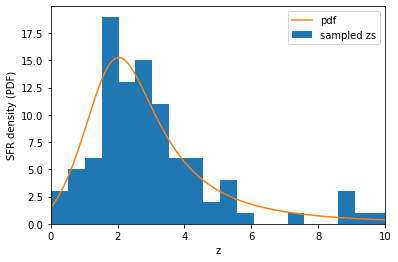

In [78]:
bins = np.linspace(z_min, z_max, num_injs)
plt.hist(z_events, bins=bins, density=False, label='sampled zs')
plt.plot(z_range, 10000*pdf_z, label="pdf")
plt.xlim(0, 10)

plt.legend()
plt.xlabel("z")
plt.ylabel("SFR density (PDF)")
plt.show()